# QAOA Tutorial

In [1]:
import pennylane as qml
from pennylane import qaoa
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize
import itertools
from functools import reduce

The goal of the PennyLane library is to provide a collection of general, yet powerful functions that the user may apply to a wide variety of use-cases.

#### Defining Circuits in Terms of Hamiltonians

Oftentimes, when considering thinking of quantum circuits or variational ansatzae, it is convenient to consider these processes as defined by a series of quantum gates. However, as it turns out, there are many instances where it is useful to think of a quantum circuit in terms of a *Hamiltonian*. For instance, in quantum mechanics, a unitary transformation of great interest is that of time-evolution:

$$U \ = \ e^{-i \hat{H} t / \hbar}$$

This unitary is clearly defined completely in terms of a Hamiltonian, $\hat{H}$ and a scalar $t$. Mimicing the general form of the time-evolution unitary, as it is the most general example of a unitary determined by a Hamiltonian, we define a time-evolution template in PennyLane, more specifically, an *approximate* time-evolution template, which implements a unitary of the form:

$$U(\hat{H}, t, n) \ = \ \displaystyle\prod_{j \ = \ 1}^{n} \displaystyle\prod_{k} e^{-i \hat{H}_k t}$$

where:

$$\hat{H} \ = \ \displaystyle\sum_{k} \hat{H}_k$$

#### Repeating Circuits

Another fundamental idea within quantum computation is repetedly applictions of quantum gates. This can be seen everywhere, from amplitude amplification in Grover's algorithm and HHL, to layers in quantum neural networks, to Trotterization in quantum simulation. We therefore define the ``qml.layer`` method in PennyLane to alternate an arbitrary unitary. This general method allows us to take a function containing quantum operations, a template, or even a single quantum gate and repeatedly apply it. For example, consider the following complicated

#### The Quantum Approximate Optimization Algorithm 

The QAOA is a variational quantum algorithm, meaning that it uses a parametrized ansatz to prepare a state, with a classical optimizer minimizing the expected value of some cost Hamiltonian with respect to the prepared state. Consider the general form of the QAOA ansatz:

$$U_{\text{QAOA}}(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_k H_M} e^{-i \gamma_k H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C}$$

This ansatz combines the two general principles that we discussed earlier: circuits determined by Hamiltonians and repetition. Therefore, many of the methods we introduce in this next section will simply be specific instances of the more general functions outlined previously.

#### Implementing QAOA in PennyLane

When defining a QAOA workflow in PennyLane, the first thing we must do is decide which optimization problem we want to solve, and construct the cost/mixer Hamiltonians. For large problems, it is often difficult to construct such Hamiltonians, as they usually involve many terms and many different interactions. Due to this, one of the main goals of the PennyLane QAOA module is to have the capabilities to provide users with cost and mixer Hamiltonians with very few lines of code. 

Within ``qml.qaoa``, there is a collection of built-in optimization problems which the user may call, in order to get the corresponding cost Hamiltonian, and a reccomended mixer Hamiltonian. For example, let's say we want to perform MaxCut on the following graph:

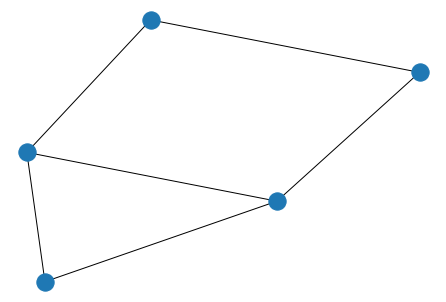

In [2]:
graph = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 0), (1, 4), (2, 4)])
nx.draw(graph)
plt.show()

where each of the number representing the nodes correspond to a wire label. We are able to construct both the cost and mixer Hamiltonians with one line of code:

In [3]:
cost_h, mixer_h = qaoa.maxcut(graph)

print("""Cost Hamiltonian:
{}""".format(cost_h))
print("-----------------------------------")
print("""Mixer Hamiltonian:
{}""".format(mixer_h))

Cost Hamiltonian:
(-0.5) [I0 I1]
+ (0.5) [Z0 Z1]
+ (-0.5) [I0 I3]
+ (0.5) [Z0 Z3]
+ (-0.5) [I1 I2]
+ (0.5) [Z1 Z2]
+ (-0.5) [I1 I4]
+ (0.5) [Z1 Z4]
+ (-0.5) [I2 I3]
+ (0.5) [Z2 Z3]
+ (-0.5) [I2 I4]
+ (0.5) [Z2 Z4]
-----------------------------------
Mixer Hamiltonian:
(1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]


With the cost and mixer Hamiltonians, we are now able to define a method that applies one layer of the QAOA ansatz:
    
**IMAGE HERE OF ONE LAYER**

To do this, we simply pass ``cost_h`` and ``mixer_h`` into ``cost_layer`` and ``mixer_layer``, respectively, which automatically build the cost and mixer layers:

$$U_{\text{Cost}} \ = \ e^{-i \gamma H_C} \ \ \ \ \ \ \ \ \ \ U_{\text{Mixer}} \ = \ e^{-i \alpha H_M}$$

Note that the two methods, ``cost_layer`` and ``mixer_layer`` are simply calls to ``ApproxTimeEvolution``, which is able to apply unitaries of the above form, with "effective times" $\gamma$ and $\alpha$:

In [4]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

The final step in preparing our QAOA circuit is to repeatedly apply the ``qaoa_layer`` to our set of wires, thus alternating the cost and mixer layers to create the full ansatz. To do this, we make use of the ``qml.layer`` method. Note that our ansatz begins in initializing the wires in an even superposition over all basis states:

In [5]:
def ansatz(params, **kwargs):
    
    for i in range(5):
        qml.Hadamard(wires=i)
    
    qml.layer(qaoa_layer, 2, params[0], params[1])

The goal of QAOA is to minimize the expected value of the cost Hamiltonian with respect to the state outputted from the QAOA circuit, which we will call $|\psi(\boldsymbol\gamma, \ \boldsymbol\alpha)\rangle$. This means we can define a *cost function* as:
    
$$F(\gamma, \ \alpha) \ = \ \langle \psi(\boldsymbol\gamma, \ \boldsymbol\alpha) | H_C | \psi(\boldsymbol\gamma, \ \boldsymbol\alpha) \rangle$$ 

There is a method in the PennyLane core that constructs exactly this kind of cost function, called ``VQECost``. Thus, to construct the cost function which we will attempt to minimize, we simply call ``VQECost`` on our ansatz circuit, cost Hamiltonian, and device (the set of qubits on which we run our algorithm):

In [6]:
dev = qml.device('default.qubit', wires=range(6))
cost_function = qml.VQECost(ansatz, cost_h, dev)

Finally, we must minimize the cost function. One of the most fundamental ideas upon which PennyLane is built is that we should view NISQ quantum circuits as differentiable and optimizable subroutines in larger quantum-classical algorithms. We have successfully defined the "quantum part" of our quantum-classical algorithm. Now, to optimize our cost function, we can make use of the large collection of tools built-into PennyLane tailored to just this task. We first define an optimizer and our initial variational parameters:

In [7]:
optimizer = qml.GradientDescentOptimizer()
params = [[0.5, 0.5], [0.5, 0.5]]

We are now able to repeatedly update the parameters for a given number of steps:

In [8]:
steps = 30

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Done Step {}/{}".format(i+1, steps))

print("Optimal Params: {}".format(params))

Done Step 1/30
Done Step 2/30


KeyboardInterrupt: 

In [51]:
@qml.qnode(dev)
def dist_circuit(gamma, alpha):
    ansatz([gamma, alpha])
    return qml.probs(wires=range(5))

final_dist = dist_circuit(params[0], params[1])
print(final_dist)

[0.00061681 0.00031541 0.00085477 0.04838701 0.0060849  0.01365931
 0.02159486 0.02159486 0.0060849  0.01365931 0.12474082 0.12474082
 0.06690561 0.00151886 0.04838701 0.00085477 0.00085477 0.04838701
 0.00151886 0.06690561 0.12474082 0.12474082 0.01365931 0.0060849
 0.02159486 0.02159486 0.01365931 0.0060849  0.04838701 0.00085477
 0.00031541 0.00061681]


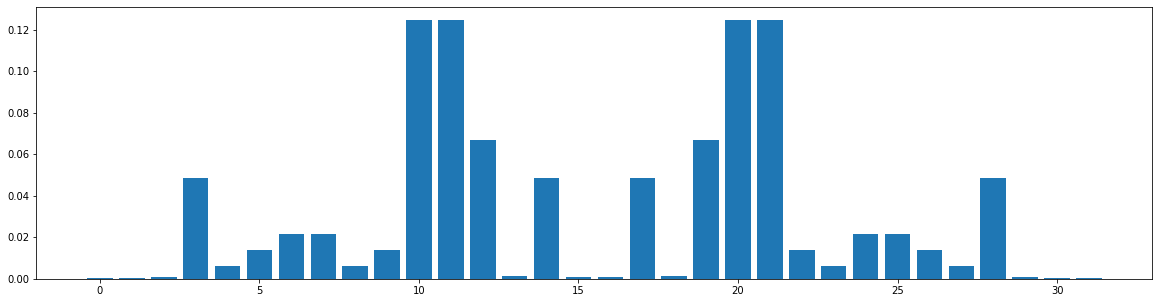

In [52]:
plt.figure(figsize=(20, 5))
plt.bar(range(2**5), final_dist)
plt.show()

In [67]:
y = []

for i in range(0, 2**5):
    cost = 0
    num = bin(i)[2:].zfill(5)
    for j, ind1 in enumerate(num):
        for k, ind2 in enumerate(num):
            if ((j, k) in graph.edges and j != k):
                if (int(ind1)+int(ind2)) % 2 == 0:
                    cost += 1
    y.append(cost)

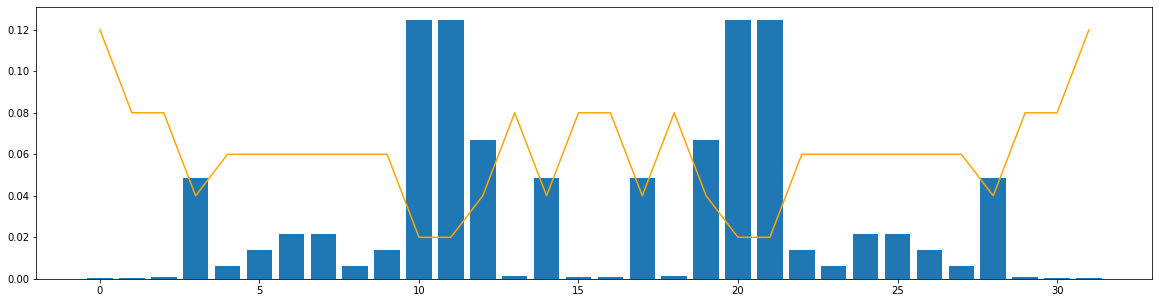

In [73]:
plt.figure(figsize=(20, 5))
plt.bar(range(2**5), final_dist)
plt.plot(range(2**5), [0.01*i for i in y], color='orange')
plt.show()

### Implementing QAOA MaxClique

We begin by defining the graph on which we perform MaxClique:

We then define the cost and mixer Hamiltonians:

Let us also plot the cost function (the expectation value of the cost Hamiltonian with respect to each basis state):

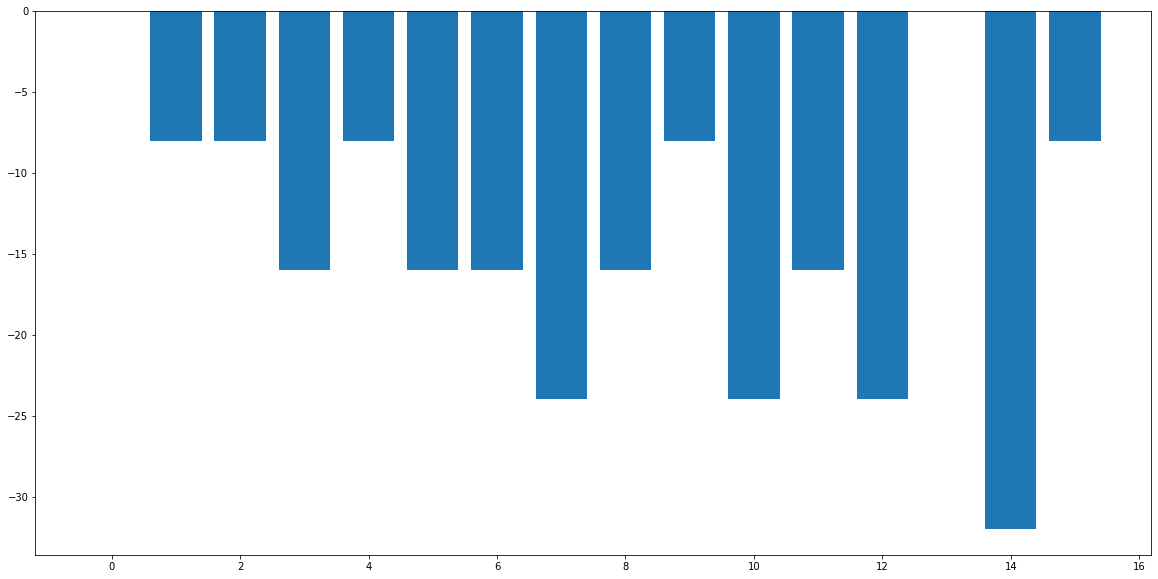

In [461]:
y = []

for i in range(0, 2**(len(wires)-1)):
    cost = 0
    num = bin(i)[2:].zfill(3)
    for j, ind1 in enumerate(num):
        for k, ind2 in enumerate(num):
            if ((j, k) in nx.complement(graph).edges and int(ind1)*int(ind2) == 1):
                cost += 6
            if ((j, k) in nx.complement(graph).edges and int(ind1)*int(ind2) == 0):
                cost -= 2
    for i in num:
        if (i == "1"):
            cost -= 8
    y.append(cost)

plt.figure(figsize=(20, 10))
plt.bar(range(2**(len(wires)-1)), y)
plt.show()

We can now create the QAOA layer corresponding to MaxClique:

In [462]:
def mixer_layer(alpha, graph):
    
    for v in graph.nodes:
        neighbors = [n for n in graph.neighbors(v)]
        for i in neighbors:
            qml.PauliX(wires=i)
        qml.MultiCX(wires=neighbors+[ancilla])
        qml.CRX(alpha, wires=[ancilla, v])
        qml.MultiCX(wires=neighbors+[ancilla])
        for i in neighbors:
            qml.PauliX(wires=i)

def maxclique_cost(graph):
    
    coeffs = []
    terms = []
    
    for v in graph.nodes:
        coeffs.append(-1)
        terms.append(qml.PauliZ(wires=v))
    
    return qml.Hamiltonian(coeffs, terms)


def cost_ham(graph):
    
    coeffs = []
    terms = []
    
    for v in graph.nodes:
        coeffs.append(-0.5)
        terms.append(qml.PauliZ(wires=v))
    
    for e in graph.edges:
        coeffs.extend([0.5, 0.5, 0.5])
        terms.extend([qml.PauliZ(e[0]) @ qml.PauliZ(e[1]), qml.PauliZ(e[0]), qml.PauliZ(e[1])])
    
    return qml.Hamiltonian(coeffs, terms)

def new_mixer_ham(graph):
    
    coeffs = []
    terms = []
    for i in graph.nodes:
        n_terms = [[qml.PauliX(i)]]+[[qml.Identity(n), qml.PauliZ(n)] for n in graph.neighbors(i)]
        n_coeffs = [[1, -1] for n in graph.neighbors(i)]
        
        final_terms = [qml.operation.Tensor(*list(m)) for m in itertools.product(*n_terms)]
        final_coeffs = [reduce(lambda x, y: x*y, list(m), 1) for m in itertools.product(*n_coeffs)]
        
        #coeffs.extend([1 for i in range(len(final_terms))])
        
        coeffs.extend(final_coeffs)
        terms.extend(final_terms)
        
        '''
        for j in final_terms:
            val = set(zip(list(j.wires), j.name))
            if val in node_values:
                node_coeffs[node_values.index(val)] += 1
            else:
                node_terms.append(j)
                node_coeffs.append(1)
        '''
    return qml.Hamiltonian(coeffs, terms)

#cost_h = maxclique_cost(graph)
#mixer_h = new_mixer_ham(graph)

In [463]:
dev = qml.device('qulacs.simulator', wires=len(wires))

@qml.qnode(dev)
def circuit(params, **kwargs):
    for i in range(4):
        qml.PauliX(wires=i)
    qml.layer(qaoa_layer, 3, params[0], params[1])
    return qml.expval(qml.PauliZ(0))

circuit([[1, 1, 1], [1, 1, 1]])
print(circuit.draw())

 0: ──X──RZ(-1.0)──╭X──RZ(1.0)──╭X──RZ(1.0)──╭X──RZ(1.0)──╭X──RZ(1.0)───H──RZ(2.0)───H──RZ(-1.0)─────────────────────────────╭X──RZ(1.0)──╭X──RZ(1.0)───╭X──RZ(1.0)──╭X──RZ(1.0)───H──RZ(2.0)───H──RZ(-1.0)─────────────────────────────╭X──RZ(1.0)──╭X──RZ(1.0)───╭X──RZ(1.0)──╭X──RZ(1.0)───H──RZ(2.0)───H────────────────────────────────────────────────────┤ ⟨Z⟩ 
 1: ──X──RZ(-1.0)──╰C───────────╰C──RZ(1.0)──│────────────│────────────╭X──RZ(1.0)──╭X──RZ(1.0)────H──RZ(2.0)───H──RZ(-1.0)──╰C───────────╰C──RZ(1.0)───│────────────│────────────╭X──RZ(1.0)──╭X──RZ(1.0)────H──RZ(2.0)───H──RZ(-1.0)──╰C───────────╰C──RZ(1.0)───│────────────│────────────╭X──RZ(1.0)──╭X──RZ(1.0)───H──RZ(2.0)───H──────────────────────────┤     
 2: ──X──RZ(-1.0)────────────────────────────╰C───────────╰C──RZ(1.0)──╰C───────────╰C──RZ(1.0)───╭X──RZ(1.0)──╭X──RZ(1.0)────H──RZ(2.0)───H──RZ(-1.0)──╰C───────────╰C──RZ(1.0)──╰C───────────╰C──RZ(1.0)───╭X──RZ(1.0)──╭X──RZ(1.0)────H──RZ(2.0)───H──RZ(-1.0)──╰C───────────╰C──RZ(1.0

**TESTING QAOA STUFF**

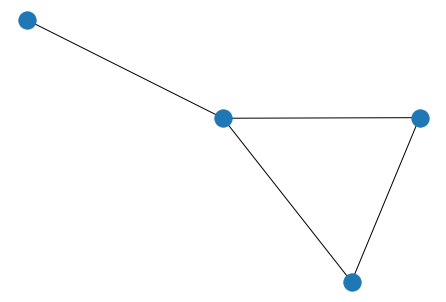

In [2]:
wires = range(4)
graph = nx.Graph([(0, 1), (1, 2), (2, 0), (2, 3)])
nx.draw(graph)
plt.show()

In [4]:
cost_h, mixer_h = qaoa.maxclique(graph, constrained=False)

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

def initialization():
    for w in wires:
        qml.Hadamard(wires=w)

(0.5) [Z0 Z3]
+ (0.0) [Z0]
+ (0.0) [Z3]
+ (0.5) [Z1 Z3]
+ (0.0) [Z1]
+ (-0.5) [Z3]
+ (0.5) [Z2]


We then define the full QAOA circuit:

In [11]:
dev = qml.device('qulacs.simulator', wires=len(wires))

def circuit(params, **kwargs):
    initialization()
    qml.layer(qaoa_layer, 3, params[0], params[1])

Next we define the device and the cost function:

In [12]:
cost_function = qml.VQECost(circuit, cost_h, dev)

Finally, we can optimize the cost function:

In [13]:
optimizer = qml.GradientDescentOptimizer()
params = [
    [np.random.randint(-100, 100)/100 for i in range(3)],
    [np.random.randint(-100, 100)/100 for i in range(3)]
]

steps = 40

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Done Step {}/{}".format(i+1, steps))

print("Optimal Params: {}".format(params))

Done Step 1/40
Done Step 2/40
Done Step 3/40
Done Step 4/40
Done Step 5/40
Done Step 6/40
Done Step 7/40
Done Step 8/40
Done Step 9/40
Done Step 10/40
Done Step 11/40
Done Step 12/40
Done Step 13/40
Done Step 14/40
Done Step 15/40
Done Step 16/40
Done Step 17/40
Done Step 18/40
Done Step 19/40
Done Step 20/40
Done Step 21/40
Done Step 22/40
Done Step 23/40
Done Step 24/40
Done Step 25/40
Done Step 26/40
Done Step 27/40
Done Step 28/40
Done Step 29/40
Done Step 30/40
Done Step 31/40
Done Step 32/40
Done Step 33/40
Done Step 34/40
Done Step 35/40
Done Step 36/40
Done Step 37/40
Done Step 38/40
Done Step 39/40
Done Step 40/40
Optimal Params: [[0.23606226496707913, -0.7051052175105696, -0.877011073583566], [-0.21857723907401674, 0.2497710306422331, 0.34433399632098477]]


In [14]:
@qml.qnode(dev)
def dist_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

final_dist = dist_circuit(params[0], params[1])
print(final_dist)

[5.55985311e-03 2.70408183e-02 5.53038040e-02 2.68974753e-01
 5.09291379e-03 3.70232826e-04 5.06591631e-02 3.68270226e-03
 5.09291379e-03 3.70232826e-04 5.06591631e-02 3.68270226e-03
 4.45808565e-02 3.24148938e-03 4.43445339e-01 3.22430629e-02]


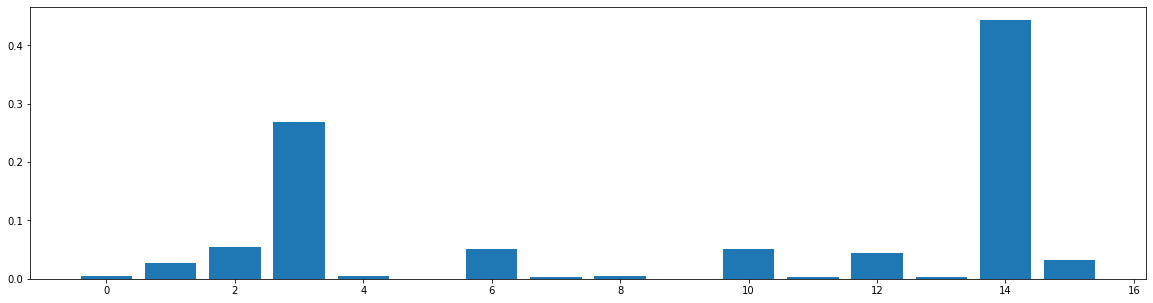

In [15]:
plt.figure(figsize=(20, 5))
plt.bar(range(2**(len(wires))), list(final_dist))
plt.show()